In [1]:
import pandas as pd
import numpy as np
from numpy import inf
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
import os
os.chdir('/Users/KevinShao/Desktop/adsi_group2leftfeet')

In [3]:
df_train = pd.read_csv('data/raw/train.csv')

In [4]:
df_train.head()

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [5]:
#Feature engineering

df_train['GP'] = df_train['GP'].abs()
df_train['BLK'] = df_train['BLK'].abs()
df_train['3P Made'] = df_train['3P Made'].abs()
df_train['3PA'] = df_train['3PA'].abs()

In [6]:
#Drop this variable as its not needed
df_train.drop('Id', axis=1, inplace=True)

In [7]:
df_train.columns = df_train.columns.str.strip()

In [8]:
print(df_train['TARGET_5Yrs'].value_counts())

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64


In [9]:
#Extract the target variable in this case the target_5yrs
target = df_train.pop('TARGET_5Yrs')

In [10]:
#Get column names for feature importance or coefficient dataframe
columns = df_train.columns

In [11]:
#Normalizing the data as some might have % and other might have higher value such as GP and MIN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)

In [12]:
#Upsmapling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=8)
x_res, y_res = sm.fit_sample(df_train, target)
print(target.value_counts(), np.bincount(y_res))

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64 [6669 6669]


In [13]:
#Splitting into training and testing
x_train_res, X_val_res, y_train_res, y_val_res = train_test_split (x_res, y_res, test_size=0.3, random_state=8)

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = RandomForestClassifier(random_state = 8)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20],
    'max_features': [2, 3, 5, 7, 9, 11, 13, 15, 18, 21],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [5],
    'n_estimators': [500, 1000, 2000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train_res, y_train_res)
grid_search.best_params_
best_grid = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

In [16]:
rf_model =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=7, 
            min_samples_leaf=1, min_samples_split=5,
            n_estimators=100, n_jobs=-1,
            random_state=8, verbose=1)

In [17]:
rf_model.fit(x_train_res,y_train_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


RandomForestClassifier(max_depth=20, max_features=7, min_samples_split=5,
                       n_jobs=-1, random_state=8, verbose=1)

In [19]:
from joblib import dump
dump(rf_model,'models/rf_upsampled.joblib')

['models/rf_upsampled.joblib']

In [21]:
y_pred=rf_model.predict(X_val_res)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [22]:
from sklearn import metrics
print("roc_auc:",metrics.accuracy_score(y_val_res, y_pred))

roc_auc: 0.9062968515742129


In [23]:
feature_imp = pd.Series(rf_model.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp

BLK        0.122485
GP         0.119218
FTM        0.060032
OREB       0.058715
FG%        0.050722
STL        0.049562
FT%        0.048326
3P%        0.047056
FTA        0.046287
AST        0.045315
REB        0.044515
DREB       0.044376
TOV        0.041844
FGM        0.041191
3P Made    0.039691
3PA        0.039539
MIN        0.036623
PTS        0.032748
FGA        0.031756
dtype: float64

No handles with labels found to put in legend.


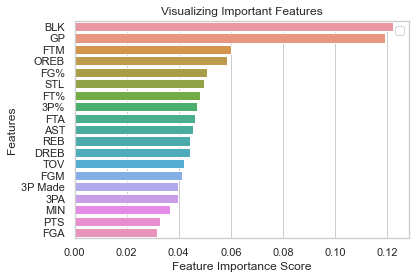

In [24]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [25]:
confusion_matrix = confusion_matrix(y_val_res, y_pred)
print(confusion_matrix)

[[1734  243]
 [ 132 1893]]


In [26]:
print(classification_report(y_val_res, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1977
           1       0.89      0.93      0.91      2025

    accuracy                           0.91      4002
   macro avg       0.91      0.91      0.91      4002
weighted avg       0.91      0.91      0.91      4002



In [27]:
#ROC of Upsampled and Hyper Parameter Tuning
roc_train=roc_auc_score(y_train_res, rf_model.predict_proba(x_train_res)[:,1])
roc_test=roc_auc_score(y_val_res, rf_model.predict_proba(X_val_res)[:,1])
print(roc_train)
print(roc_test)

0.9999997705332367
0.9643021912487433


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


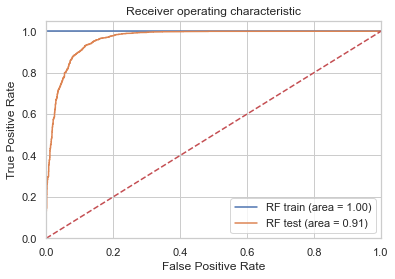

In [29]:
rf_roc_auc_test = roc_auc_score(y_val_res, rf_model.predict(X_val_res))
rf_roc_auc_train = roc_auc_score(y_train_res, rf_model.predict(x_train_res))
fpr_test, tpr_test, thresholds_test = roc_curve(y_val_res, rf_model.predict_proba(X_val_res)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_res, rf_model.predict_proba(x_train_res)[:,1])
plt.figure()
plt.plot(fpr_train, tpr_train, label='RF train (area = %0.2f)' % rf_roc_auc_train)
plt.plot(fpr_test, tpr_test, label='RF test (area = %0.2f)' % rf_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

In [ ]:
df = pd.read_csv('data/raw/test.csv')

In [ ]:
df['GP'] = df['GP'].abs()
df['BLK'] = df['BLK'].abs()
df['3P Made'] = df['3P Made'].abs()
df['3PA'] = df['3PA'].abs()

In [ ]:
df1=df.loc[:, df.columns != 'Id']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(df1)

In [ ]:
y_pred_sub = pd.DataFrame({'TARGET_5Yrs':rf_model.predict(df1)})

In [ ]:
df_out = pd.merge(df.iloc[:, 0], y_pred_sub, left_index = True, right_index = True)

In [ ]:
df_out.to_csv(r'data/submission/rf_submission.csv', index = False)